### Meta-learning
- Calculate performance across sessions and bin sessions into roughly 10 sessions per bin. This one also calculates "struc_in_unstruc" sessions

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects

exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess

perf_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    mab = exp.b2a.filter_by_trials(min_trials=100, clip_max=150)
    perf = mab.get_optimal_choice_probability(bin_size=10)

    df = pd.DataFrame(data=perf, columns=np.arange(perf.shape[1]) + 1)
    df["session_bin"] = np.arange(perf.shape[0]) + 1
    df = df.melt(id_vars="session_bin", var_name="trial_id", value_name="perf")
    df.sort_values(by=["session_bin", "trial_id"], inplace=True)

    df["name"] = exp.sub_name
    df["grp"] = "struc" if mab.is_structured else "unstruc"

    perf_df.append(df)

    if ~mab.is_structured:
        mab2 = exp.b2a.filter_by_trials(min_trials=100, clip_max=150)
        session_prob_sum = mab2.probs[mab2.is_session_start.astype(bool)].sum(axis=1)
        good_sessions = mab2.sessions[session_prob_sum == 1]
        assert np.all(good_sessions)
        mab2 = mab2.filter_by_session_id(good_sessions)

        perf = mab2.get_optimal_choice_probability(bin_size=10)

        df2 = pd.DataFrame(data=perf, columns=np.arange(perf.shape[1]) + 1)
        df2["session_bin"] = np.arange(perf.shape[0]) + 1
        df2 = df2.melt(id_vars="session_bin", var_name="trial_id", value_name="perf")
        df2.sort_values(by=["session_bin", "trial_id"], inplace=True)

        df2["name"] = exp.sub_name
        df2["grp"] = "struc_in_unstruc"
        perf_df.append(df2)

perf_df = pd.concat(perf_df, ignore_index=True)
mab_subjects.GroupData().save(perf_df, "perf_100min150max_10bin")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from statannotations.Annotator import Annotator
from statplot_utils import stat_kw

fig = plotting.Fig(1, 3, size=(11, 3), num=1)

grpdata = mab_subjects.GroupData()
df = grpdata.perf_100min150max_10bin
df1 = df[((df["session_bin"] > 30) & (df["grp"] == "unstruc"))]
df1["grp"] = "unstruc_late"
df = pd.concat([df, df1], ignore_index=True)

ax = fig.subplot(fig.gs[0])
# ax.axhline(0, color="gray", lw=0.8, zorder=0)
hue_order = ["unstruc", "struc", "struc_in_unstruc", "unstruc_late"]
plot_kw = dict(data=df, x="trial_id", y="perf", hue="grp", hue_order=hue_order, ax=ax)
sns.lineplot(
    palette=["#f77189", "#36ada4", "#a48cf4", "#f7c94a"],
    # edgecolor="white",
    # facecolor=(0, 0, 0, 0),
    # alpha=0.4,
    err_kws=dict(edgecolor="none"),
    errorbar="se",
    **plot_kw,
)


# orders = ["unstruc", "struc"]
# pairs = [(("unstruc"), ("struc"))]
# annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
# annotator.configure(test="Kruskal", **stat_kw, color="k", verbose=True)
# annotator.apply_and_annotate()
# annotator.reset_configuration()
# ax.grid(True)
ax.set_title("Performance")
ax.set_ylabel("Performance")
ax.set_ylim(0.45, 1)
ax.set_xticks([1, 50, 100, 150])
# ax.legend("")

### Performance in all, easy, and hard sessions
- Comparing Unstruc and Struc where the difference in probability is more than 0.4 

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects

exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess
trial_filter = dict(min_trials=100, clip_max=100)

perf_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(**trial_filter).filter_by_deltaprob(
        delta_min=0.05, delta_max=None
    )
    mab_easy = task.filter_by_deltaprob(delta_min=0.4)
    mab_hard = task.filter_by_deltaprob(delta_min=0.1, delta_max=0.35)

    perf = task.get_optimal_choice_probability()
    perf_easy = mab_easy.get_optimal_choice_probability()
    perf_hard = mab_hard.get_optimal_choice_probability()

    df = pd.DataFrame(
        dict(
            trial_id=np.arange(perf.size) + 1,
            perf=perf,
            perf_easy=perf_easy,
            perf_hard=perf_hard,
            name=exp.sub_name,
            grp="struc" if task.is_structured else "unstruc",
            first_experience=True if "Exp1" in exp.sub_name else False,
        )
    )
    perf_df.append(df)

perf_df = pd.concat(perf_df, ignore_index=True)
mab_subjects.GroupData().save(perf_df, "perf_difficulty_level")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from mab_colors import colors_2arm
from statplotannot.plots import SeabornPlotter, fix_legend

fig = plotting.Fig(5, 3, num=1, fontsize=10)

grpdata = mab_subjects.GroupData()
df = grpdata.perf_difficulty_level
df = df[df["first_experience"] == True]

# ax = fig.subplot(fig.gs[0])
hue_order = ["unstruc", "struc"]
linestyles = ["-", "--", ":"]
titles = [
    "All permutations",
    "Easy\n(DeltaP>=40)",
    "Hard\n(DeltaP<=30)",
]

for i, y in enumerate(["perf", "perf_easy", "perf_hard"]):

    ax = fig.subplot(fig.gs[i])
    plot_kw = dict(data=df, x="trial_id", y=y, hue="grp", hue_order=hue_order, ax=ax)
    sns.lineplot(
        palette=colors_2arm(),
        lw=1.1,
        # ls=linestyles[i],
        ls="-",
        err_kws=dict(edgecolor="none"),
        errorbar="se",
        **plot_kw,
    )
    ax.set_ylim(0.45, 1)
    fix_legend(ax, only_labels=True, fw="bold", fs=10)
    ax.grid(axis="y", zorder=-1, alpha=0.5)
    ax.set_ylabel("Pr(Optimal Choice)")
    ax.set_xticks([1, 25, 50, 75, 100])
    ax.set_title(titles[i])

# ax.legend("")

### Performance matrix
- Bins are represented by probability combination

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from scipy.ndimage import gaussian_filter1d

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess
# exps = mab_subjects.unstruc.Grump

prob_perf_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    # print(task.probs_corr)
    # task.auto_block_window_ids()
    # mask = task.block_ids == 2
    # task = task._filtered(mask).filter_by_trials(100, 100)

    perf_mat, unique_probs = task.get_performance_prob_grid(n_last_trials=99)

    df = pd.DataFrame(
        {
            "probs": [unique_probs],
            "perf_mat": [perf_mat],
            "name": exp.sub_name,
            "grp": exp.group_tag,
            "lesion": exp.lesion_tag,
            "dataset": exp.data_tag,
        }
    )
    df["name"] = exp.sub_name
    df["grp"] = exp.group_tag

    prob_perf_df.append(df)

prob_perf_df = pd.concat(prob_perf_df, ignore_index=True)
mab_subjects.GroupData().save(prob_perf_df, "perf_probability_matrix")

In [ ]:
import matplotlib.pyplot as plt
from neuropy.plotting import Fig
import seaborn as sns
from scipy.stats import binned_statistic_2d
from mab_colors import Palette2Arm
from statplotannot.plots import fix_legend
import mab_subjects
import numpy as np
from scipy.ndimage import gaussian_filter
from palettable.scientific.sequential import GrayC_7
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as ticker


bounds = np.linspace(0.4, 1, 15)
norm = BoundaryNorm(bounds, ncolors=256)

fig = Fig(4, 2, size=(8.5, 11), fontsize=12)

df = mab_subjects.GroupData().perf_probability_matrix.latest
# df = df[df["lesion"] == "pre_lesion"]
for g, grp in enumerate(["struc", "unstruc"]):
    df_grp = df[df["grp"] == grp]
    perf_mean = df_grp["perf_mat"].mean()
    # perf_mean = gaussian_filter(perf_mean, sigma=0.1)
    # perf_mean = np.tril(perf_mean, k=0)
    mask = np.triu(np.ones_like(perf_mean, dtype=bool), k=0)

    perf_mean[mask] = np.nan

    ax = fig.subplot(fig.gs[g])

    im = ax.pcolormesh(
        perf_mean.T,
        # cmap=GrayC_7.mpl_colormap,
        cmap="turbo",
        shading="auto",
        # vmin=0.6,
        # vmax=1,
        norm=norm,
    )
    ticks = np.arange(0, 6) + 0.5
    ax.set_xticks(ticks, [20, 30, 40, 60, 70, 80])
    ax.set_yticks(ticks, [20, 30, 40, 60, 70, 80])
    ax.set_xlim(1, 6)
    ax.set_ylim(0, 5)
    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.set_xlabel("Higher reward probability")
    ax.set_ylabel("Lower reward probability")

    cb = plt.colorbar(im, ax=ax, shrink=0.7)
    cb.set_label("P(High)")
    formatter = ticker.FormatStrFormatter("%.2f")
    cb.ax.yaxis.set_major_formatter(formatter)
    ax.set_title(f"{grp} sessions\n(mean of last 99 trials)")

### Entropy of choices in equal probability arms

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from scipy.ndimage import gaussian_filter1d

exps = mab_subjects.unstruc.allsess

entropy_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100).filter_by_deltaprob(
        delta_min=0, delta_max=0
    )
    entropy = task.get_choice_entropy()

    df = pd.DataFrame(
        {
            "trial_id": np.arange(len(entropy)) + 1,
            "entropy": entropy,
            "name": exp.sub_name,
            "grp": "struc" if task.is_structured else "unstruc",
            "first_experience": True if "Exp1" in exp.sub_name else False,
        }
    )

    entropy_df.append(df)

entropy_df = pd.concat(entropy_df, ignore_index=True)
mab_subjects.GroupData().save(entropy_df, "entropy_equal_probs")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import mab_subjects
from neuropy import plotting
from mab_colors import colors_2arm

df = mab_subjects.GroupData().entropy_equal_probs
df = df[df["first_experience"] == True]

fig = plotting.Fig(1, 3, size=(11, 3), num=1)
ax = fig.subplot(fig.gs[0])
sns.lineplot(data=df, x="trial_id", y="entropy", color=colors_2arm()[0], errorbar="se")
ax.set_title("Entropy of choosing between equal probability arms")
ax.set_ylim(0, 1)
ax.set_ylabel("Entropy")
# ax.legend_.remove()

### Impure environments individual metrics

In [ ]:
import matplotlib.pyplot as plt
from banditpy.plots import plot_trial_by_trial_2Arm
from neuropy import plotting
from scipy import stats
import mab_subjects
import numpy as np


exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

fig = plotting.Fig(9, 6)

for i, exp in enumerate(exps):

    task = exp.b2a
    probs_corr = task.probs_corr

    if probs_corr < -0.5:
        grp = "struc"
    else:
        grp = "unstruc"

    H, xedges, yedges = task.get_prob_hist_2d(stat="prop")
    # choices[choices == 1] = 2
    # choices[task.choices == 2] = 1
    # task.choices = choices

    perf = task.filter_by_trials(
        min_trials=100, clip_max=100
    ).get_optimal_choice_probability()

    ax = fig.subplot(fig.gs[3 * i])
    ax.plot(perf, color="k")
    # task.plot_trial_by_trial(ax=ax)
    ax.set_ylim(0.4, 0.9)
    ax.set_xlabel("Trial_id")
    ax.set_ylabel("Choice (High)")
    ax.set_title(f"{exp.sub_name}'s performance")

    ax2 = fig.subplot(fig.gs[3 * i + 1])
    cplot = ax2.pcolormesh(
        xedges,
        yedges,
        H.T,
        cmap="hot",
        vmin=0,
        # vmax=14,
        shading="auto",
    )
    cb = plt.colorbar(cplot, ax=ax2, shrink=0.5)
    # ax2.imshow(prob_mat)
    ax2.set_xlabel("Prob1")
    ax2.set_ylabel("Prob2")
    ax2.set_title(f"{exp.sub_name}'s probability combinations")
    # ax2.set_xticks([0.2, 0.3, 0.4, 0.6, 0.7, 0.8])
    # ax2.set_yticks([0.2, 0.3, 0.4, 0.6, 0.7, 0.8])
    cb.set_label("Counts")

    ax3 = fig.subplot(fig.gs[3 * i + 2])
    h, bins = task.get_trials_hist()

    ax3.plot(bins, h, color="k")
    ax3.set_xlim(0, 300)

###  Impure: Overall performance
- Compares unstruc and struc across all combinations, pure combinations, and impure combinations.

In [2]:
import matplotlib.pyplot as plt
from banditpy.plots import plot_trial_by_trial_2Arm
from neuropy import plotting
from scipy import stats
import mab_subjects
import numpy as np
import pandas as pd


exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

perf_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)

    task = exp.b2a
    probs_corr = task.probs_corr
    print(probs_corr)

    task_filt = task.filter_by_trials(min_trials=100, clip_max=100)
    perf_overall = task_filt.get_optimal_choice_probability()
    probs_all = task_filt.probs

    df = pd.DataFrame()

    corr_mask = probs_all.sum(axis=1) == 1.0  # correlated combinations
    uncorr_mask = ~corr_mask  # uncorrelated combinations

    perf_corr = task_filt._filtered(corr_mask).get_optimal_choice_probability()
    perf_uncorr = task_filt._filtered(uncorr_mask).get_optimal_choice_probability()

    df["trial_id"] = np.arange(perf_overall.shape[0]) + 1
    df["All"] = perf_overall
    df["Correlated"] = perf_corr
    df["Uncorrelated"] = perf_uncorr
    df["name"] = exp.sub_name
    df["grp"] = exp.group_tag
    perf_df.append(df)

perf_df = pd.concat(perf_df, ignore_index=True)
mab_subjects.GroupData().save(perf_df, "perf_all_corr_uncorr")

BGM0
-0.16100970983075846
BGF1
-0.26181542592091606
BGF2
-0.2240528227865245
BGF3
-0.23921350691281995
BGM5
-0.24613330448813017
Messi
-0.2072254403457084
Neymar
-0.1924344796297926
Son
-0.14568932197914772
BGM1
-0.8004130045848377
BGF0
-0.759307529536418
BGM3
-0.7548972384372281
BGM4
-0.7748551325732014
BGF4
-0.795601106057604
Gavi
-0.7976553834157815
Haaland
-0.7849173475001046
Pedri
-0.7176044476250468
Xavi
-0.8245391294066942
[GroupData] Saved: perf_all_corr_uncorr_20260210_135616.npy


'perf_all_corr_uncorr_20260210_135616.npy'

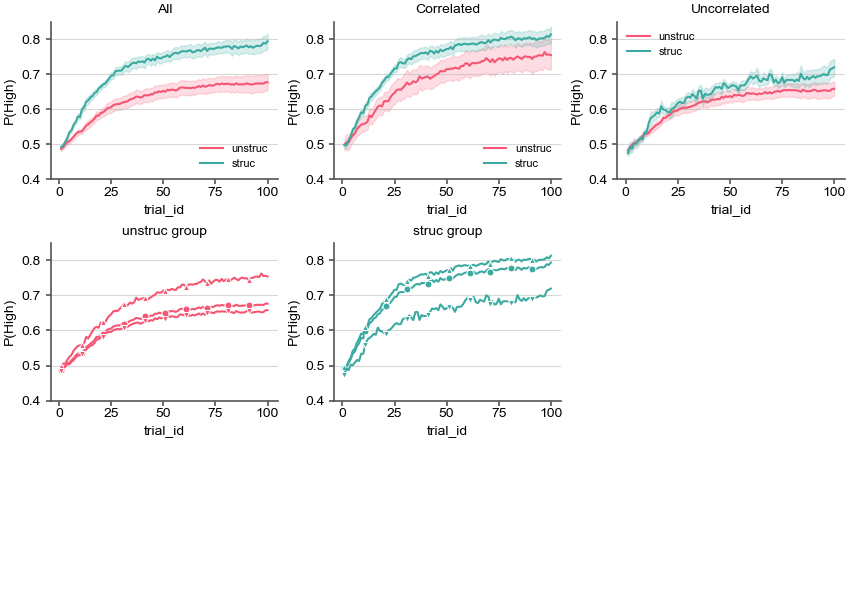

In [4]:
from statplotannot.plots import SeabornPlotter, fix_legend
from mab_colors import Palette2Arm
import seaborn as sns
from statplotannot.plots import Fig
import mab_subjects

perf_df = mab_subjects.GroupData().perf_all_corr_uncorr.latest

fig = Fig(3, 3, size=(8.5, 6), fontsize=10)

for i, y in enumerate(["All", "Correlated", "Uncorrelated"]):
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=perf_df,
        x="trial_id",
        y=y,
        hue="grp",
        palette=Palette2Arm().as_dict(),
        errorbar="se",
    )
    fix_legend(ax)
    ax.set_ylim(0.4, 0.85)
    ax.set_ylabel("P(High)")
    ax.set_title(y)
    ax.grid(axis="y", zorder=-1, alpha=0.5)

markers = ["o", "^", "v"]
columns = ["All", "Correlated", "Uncorrelated"]
for i, grp in enumerate(["unstruc", "struc"]):
    ax = fig.subplot(fig.gs[1, i])
    df_new = perf_df[perf_df["grp"] == grp]

    for c, col in enumerate(columns):
        sns.lineplot(
            data=df_new,
            x="trial_id",
            y=col,
            ax=ax,
            hue="grp",
            palette=Palette2Arm().as_dict(),
            errorbar=None,
            marker=markers[c],
            markevery=10,
            markersize=5,
            # alpha=0.5,
        )
    # fix_legend(ax)
    ax.legend_.remove()
    ax.set_ylim(0.4, 0.85)
    ax.set_ylabel("P(High)")
    ax.set_title(f"{grp} group")
    ax.grid(axis="y", zorder=-1, alpha=0.5)
    # ax.legend(labels=[label.split(" ")[0] for label in columns])

figpath = mab_subjects.figpath
fig.savefig(figpath / "choice_performance_corr_uncorr.png", dpi=300)

### Performance at specific transitions
Viewing performance for sessions that transitioned from different levels of difficulty levels:
- From hard to easy
- From easy to hard
- From hard to hard
- From easy to easy

Easy is defined as $\Delta P \ge 0.3$ $\newline$
Hard is defined as $\Delta P < 0.3$

In [ ]:
import matplotlib.pyplot as plt
import mab_subjects
import numpy as np
import pandas as pd


exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

perf_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)

    task = exp.b2a
    session_ids = task.session_ids[task.is_session_start.astype(bool)]
    probs = task.probs[task.is_session_start.astype(bool), :]
    delta_probs = np.abs(probs[:, 0] - probs[:, 1])
    delta_probs[delta_probs >= 0.3] = 1
    delta_probs[delta_probs < 0.3] = -1

    delta_diff = np.diff(delta_probs, prepend=0)

    he_mask = session_ids[delta_diff == 2]  # hard to easy
    eh_mask = session_ids[delta_diff == -2]  # easy to hard
    hh_mask = session_ids[(delta_diff == 0) & (delta_probs == -1)]  # hard to hard
    ee_mask = session_ids[(delta_diff == 0) & (delta_probs == 1)]  # easy to easy

    get_perf = (
        lambda ids: task.filter_by_session_id(ids=ids)
        .filter_by_trials(100, 100)
        .get_optimal_choice_probability()
    )

    df = pd.DataFrame()
    df["trial_id"] = np.arange(100) + 1
    df["perf_hard_to_easy"] = get_perf(he_mask)
    df["perf_easy_to_hard"] = get_perf(eh_mask)
    df["perf_hard_to_hard"] = get_perf(hh_mask)
    df["perf_easy_to_easy"] = get_perf(ee_mask)
    df["name"] = exp.sub_name
    df["grp"] = exp.group_tag
    perf_df.append(df)

perf_df = pd.concat(perf_df, ignore_index=True)
mab_subjects.GroupData().save(perf_df, "perf_easy_hard_transitions")

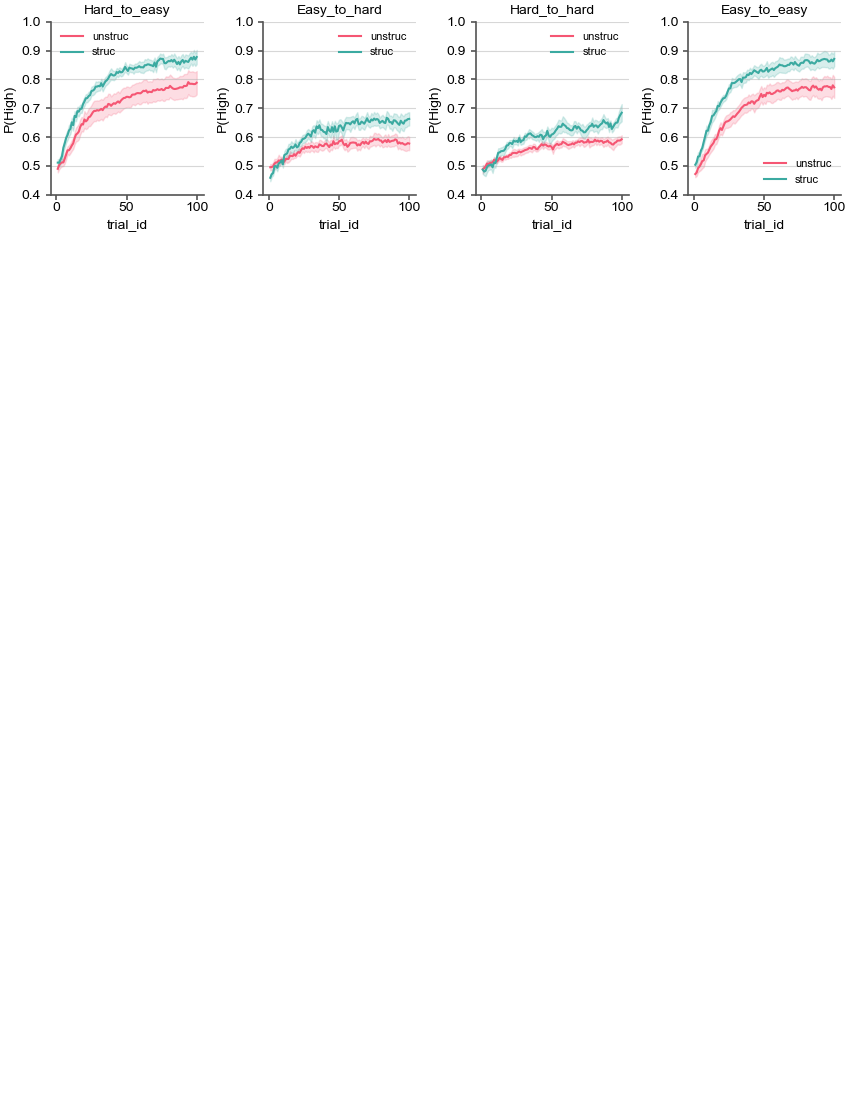

In [122]:
from neuropy import plotting
from statplotannot.plots import SeabornPlotter
import mab_subjects
from mab_colors import Palette2Arm

perf_df = mab_subjects.GroupData().perf_easy_hard_transitions.latest

fig = plotting.Fig(6, 4, fontsize=10)
transitions = [
    "perf_hard_to_easy",
    "perf_easy_to_hard",
    "perf_hard_to_hard",
    "perf_easy_to_easy",
]

for i, y in enumerate(transitions):
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=perf_df,
        x="trial_id",
        y=y,
        hue="grp",
        palette=Palette2Arm().as_dict(),
        errorbar="se",
        ax=ax,
    )
    fix_legend(ax)
    ax.set_ylim(0.4, 1)
    ax.set_ylabel("P(High)")
    ax.set_title(y.replace("perf_", "").capitalize())
    ax.grid(axis="y", zorder=-1, alpha=0.5)

### Lesion: Overall performance

In [ ]:
from scipy import stats
import mab_subjects
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d


exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess

perf_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)

    task = exp.b2a
    # task.auto_block_window_ids()
    # mask = task.block_ids == 1
    # task = task._filtered(mask)

    task = task.filter_by_trials(min_trials=100, clip_max=100).filter_by_deltaprob(
        delta_min=0.05
    )

    perf_overall = task.get_optimal_choice_probability()

    df = pd.DataFrame()
    df["trial_id"] = np.arange(perf_overall.shape[0]) + 1
    df["performance"] = gaussian_filter1d(perf_overall, sigma=1)
    df["name"] = exp.sub_name
    df["grp"] = exp.group_tag
    df["dataset"] = exp.data_tag
    df["lesion"] = exp.lesion_tag

    perf_df.append(df)

    if exp.group_tag == "unstruc":
        dependent_mask = (task.probs.sum(axis=1) > 0.98) & (
            task.probs.sum(axis=1) < 1.01
        )
        task_dep = task._filtered(dependent_mask)
        perf_dep = task_dep.get_optimal_choice_probability()

        df = pd.DataFrame()
        df["trial_id"] = np.arange(perf_overall.shape[0]) + 1
        df["performance"] = gaussian_filter1d(perf_dep, sigma=1)
        df["name"] = exp.sub_name
        df["grp"] = "struc_in_unstruc"
        df["dataset"] = exp.data_tag
        df["lesion"] = exp.lesion_tag

        perf_df.append(df)


perf_df = pd.concat(perf_df, ignore_index=True)
mab_subjects.GroupData().save(perf_df, "perf_AAdataset_Block1")

In [ ]:
from statplotannot.plots import SeabornPlotter, fix_legend
from mab_colors import colors_2arm
import seaborn as sns
from neuropy import plotting
import mab_subjects

fig = plotting.Fig(3, 3, size=(8.5, 6), fontsize=10)

perf_df = mab_subjects.GroupData().perf_AAdataset_Block1.latest
# perf_df = perf_df[perf_df["dataset"] == "ACdataset"]
df1 = perf_df[perf_df["lesion"].isin(["pre_lesion"])]
df2 = perf_df[perf_df["lesion"].isin(["pre_lesion", "post_lesion_OFC"])]
df3 = perf_df[perf_df["lesion"].isin(["pre_lesion", "naive_lesion_OFC"])]

for d, df in enumerate([df1]):

    df["grp_new"] = df["grp"] + "_" + df["lesion"]

    ax = fig.subplot(fig.gs[d])
    sns.lineplot(
        data=df,
        x="trial_id",
        y=y,
        hue="grp_new",
        # palette=colors_2arm(),
        palette=["orange", "green"],
        hue_order=["unstruc", "struc"],
        errorbar="se",
    )
    fix_legend(ax)
    ax.set_ylim(0.4, 1)
    ax.set_ylabel("P(High)")
    ax.set_title(y)
    ax.grid(axis="y", zorder=-1, alpha=0.5)

for d1, df in enumerate([df2, df3]):

    df_unstruc = df[df["grp"] == "unstruc"]
    df_struc = df[df["grp"] == "struc"]
    colors = ["orange", "green"]

    for d2, df_temp in enumerate([df_unstruc, df_struc]):
        df_temp["grp_new"] = df_temp["grp"] + "_" + df_temp["lesion"]

        ax = fig.subplot(fig.gs[d1 + 1, d2])
        sns.lineplot(
            data=df_temp,
            x="trial_id",
            y=y,
            hue="grp_new",
            # palette=colors_2arm(),
            palette=[colors[d2], "gray"],
            # hue_order=["unstruc_pre_lesion", "struc_pre_lesion"],
            errorbar="se",
        )
        fix_legend(ax)
        ax.set_ylim(0.4, 1)
        ax.set_ylabel("P(High)")
        ax.set_title(y)
        ax.grid(axis="y", zorder=-1, alpha=0.5)

### Aarushi's code for performance matrix/curve

In [ ]:
# PI matrix for diff rew prob combinations - Unstr animals

# ---------------------------

# Unstructured animals: paths

# ---------------------------

unstructured_paths_unsubsetted = {
    "Torres": r"D:\Data\mab\ACdataset\Torres\torres.csv",
    "Aggro": r"D:\Data\mab\ACdataset\Aggro\pre_lesion\Aggro_Pre.csv",
    "Auroma": r"D:\Data\mab\ACdataset\Auroma\Auroma.csv",
    "Grump": r"D:\Data\mab\ASdataset\Grump\GrumpExp1Unstructured\GrumpExp1Unstructured.csv",
}


def load_animals(unstructured_paths_unsubsetted):
    data = {}
    for animal, path in unstructured_paths_unsubsetted.items():
        data[animal] = pd.read_csv(path)
    return data


# ---------------------------
# Function: Compute performance index
# ---------------------------


def calculate_performance_index(df):
    df = df.copy()
    df["maxrp"] = df[["rewprobfull1", "rewprobfull2"]].max(axis=1)
    df["hard_regret"] = (df["maxrp"] - df["rw"]).apply(lambda x: 0 if x == 0 else 1)
    return 1 - df["hard_regret"]


def plot_combined_performance(
    animal_dict,
    cmap="viridis",
    svg_name=None,
    remove_diagonal=False,
    title=None,
    fontsize=18,
):
    all_dfs = []
    # Compute PI for each animal
    for animal, df in animal_dict.items():
        df = df.copy()
        df["PI"] = calculate_performance_index(df)
        # Ensure maxp ≥ minp
        df["pair"] = list(zip(df["rewprobfull1"], df["rewprobfull2"]))
        df["pair"] = df["pair"].apply(lambda x: tuple(sorted(x, reverse=True)))
        all_dfs.append(df[["pair", "PI"]])

    combined = pd.concat(all_dfs)
    # Average PI
    avg_df = combined.groupby("pair")["PI"].mean().reset_index()
    avg_df["maxp"] = avg_df["pair"].apply(lambda x: int(x[0]))
    avg_df["minp"] = avg_df["pair"].apply(lambda x: int(x[1]))

    # -----------------------------------------
    # FULL probability grid, including 50
    # -----------------------------------------

    full_probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    # We want minp on Y and maxp on X
    mat = avg_df.pivot_table(index="minp", columns="maxp", values="PI").reindex(
        index=full_probs, columns=full_probs
    )
    # Sort so 10 (0.1) is near origin (bottom-left)
    mat = mat.sort_index(ascending=True)
    mat = mat[sorted(mat.columns)]
    # -----------------------------------------
    # BLANK OUT diagonal (same-probability pairs)
    # -----------------------------------------

    for p in full_probs:
        mat.loc[p, p] = None  # removes annotation + color from heatmap
    # --- PLOT ---

    plt.figure(figsize=(10, 8))

    sns.heatmap(
        mat,
        annot=False,
        fmt=".2f",
        cmap=cmap,
        vmin=0,
        vmax=1,
        linewidths=1.5,
        linecolor="white",
        square=True,
        # annot_kws={"size": fontsize - 2},
        mask=mat.isna(),  # hide diagonal cleanly
    )

    # Tick labels as probabilities 0.1–0.9

    prob_labels = [p / 100 for p in full_probs]
    plt.xticks(
        ticks=range(len(full_probs)), labels=prob_labels, fontsize=fontsize, rotation=0
    )

    plt.yticks(ticks=range(len(full_probs)), labels=prob_labels, fontsize=fontsize)

    # Lower prob (0.1) closest to origin → Y-axis invert

    plt.gca().invert_yaxis()
    plt.xlabel("Higher reward probability", fontsize=fontsize + 2)
    plt.ylabel("Lower reward probability", fontsize=fontsize + 2)
    if title is not None:
        plt.title(title, fontsize=fontsize + 4, pad=15)
    if svg_name is not None:
        plt.savefig(svg_name, format="svg", dpi=300, bbox_inches="tight")
    plt.show()


unstructured_dfs = load_animals(unstructured_paths_unsubsetted)

plot_combined_performance(
    unstructured_dfs,
    cmap="Blues",  # use whatever cmap you like
    remove_diagonal=True,
    svg_name="unstructured_PI_no_diag.svg",
    # title="Unstructured Environment — Performance Index",
    fontsize=20,  # perfect size for posters
)

### Performance over time

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from numpy.lib.stride_tricks import sliding_window_view

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

perf_df = []
for e, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    session_ids = np.unique(task.session_ids)
    session_groups = sliding_window_view(session_ids, window_shape=50)[::10]
    max_perf = [
        task.filter_by_session_id(ids=sess_grp)
        .get_optimal_choice_probability()[-20:]
        .mean()
        for sess_grp in session_groups
    ]
    max_perf = np.array(max_perf)

    df = pd.DataFrame(
        {
            "sess_grp_id": np.arange(len(max_perf)) + 1,
            "max_perf": max_perf,
            "name": exp.sub_name,
            "grp": exp.group_tag,
        }
    )
    perf_df.append(df)

perf_df = pd.concat(perf_df, ignore_index=True)
mab_subjects.GroupData().save(perf_df, "perf_sliding")

In [ ]:
from neuropy import plotting
from statplotannot.plots import SeabornPlotter

fig = plotting.Fig(7, 3)

df = mab_subjects.GroupData().perf_sliding.latest

names = df["name"].unique()

for n, name in enumerate(names):
    df_name = df[df["name"] == name]

    ax = fig.subplot(fig.gs[n])
    ax.plot(df_name["sess_grp_id"], df_name["max_perf"], color="k", marker="o", lw=1)
    ax.set_ylim(0.4, 1)